In [1]:
%matplotlib inline

In [2]:
import numpy as np
import uncertainties
import yaml
import scipy.integrate
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from eFFORT.SLBToU.BToVLNu import BToVLNuBCL
from eFFORT.utility import PDG

In [3]:
def init_plot_style():
    """Define the rcParams for the plot. Requires matplotlib to be imported as mpl."""
    my_rc_params = {
        "xtick.direction": "out",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "out",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 0,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 11,
        "axes.grid": False,
        "ytick.right": False,
        "xtick.top": False
    }
    for key in my_rc_params.keys():
        mpl.rcParams[key] = my_rc_params[key]

init_plot_style()

# B to Rho

In [4]:
# Read in LCSR calculation
lcsr_coefficients = np.load('../../eFFORT/data/B{}_LCSR_central.npy'.format("rho"))
lcsr_coefficients_cov = np.load('../../eFFORT/data/B{}_LCSR_covariance.npy'.format("rho"))

hflav_Vub = 3.65e-3
hflav_Vub_cov = 0.09e-3**2 + 0.11e-3**2

# Read in legacy spectrum
with open("../fit_results/fit_result_rho.yaml") as f:
    fit_result_rho = yaml.load(f, Loader=yaml.FullLoader)

fitted_coefficients = np.array(fit_result_rho["central_values"])[1:]
fitted_covariance = np.array(fit_result_rho["covariance_matrix"])[1:, 1:]

fitted_Vub = np.array(fit_result_rho["central_values"])[0]
fitted_Vub_cov = np.array(fit_result_rho["covariance_matrix"])[0, 0]

m_V = 0.78265 
# V_ub = 3.65e-3  # +- 0.09 +- 0.11 
V_ub = 1
m_tau = 1.77682

In [5]:
N_integrations = 10000

In [6]:
bcl_integration = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=V_ub)
bcl_tau_integration = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=m_tau, V_ub=V_ub)

In [7]:
def integrate_rate(bcl, prandom, q2_min, q2_max):
    """Integrate the differential rate dGamma/dq2.
    
    Arguments:
        bcl: eFFORT class
        prandom: array of coefficients sampled from a multivariate normal distribution
        q2min: integrate from
        q2max: integrate to
    
    """
    
    def mc_integration_wrapper(x, bcl, coefficients):
        """Minimalistic wrapper for use with `scipy.integrate.quad`."""
        bcl.coefficients = coefficients
        return bcl.dGamma_dq2(x)
    
    return np.array([
        scipy.integrate.quad(lambda x: mc_integration_wrapper(x, bcl, pran), q2_min, q2_max)[0] for pran in prandom
    ])

q2min = bcl_integration.q2min
q2max = bcl_integration.q2max
m_tau2 = bcl_tau_integration.q2min

## R(V), q2min = 0

In [8]:
# Integrate from 0 to q2max
q2min = bcl_integration.q2min
q2max = bcl_integration.q2max
m_tau2 = bcl_tau_integration.q2min

In [9]:
prandom = scipy.stats.multivariate_normal.rvs(mean=lcsr_coefficients, cov=lcsr_coefficients_cov, size=N_integrations)
integration_result_zma_lcsr = integrate_rate(bcl_integration, prandom, q2min, q2max)
integration_result_tau_lcsr = integrate_rate(bcl_tau_integration, prandom, m_tau2, q2max)

In [10]:
prandom = scipy.stats.multivariate_normal.rvs(mean=fitted_coefficients, cov=fitted_covariance, size=N_integrations)
integration_result_zma_fit = integrate_rate(bcl_integration, prandom, q2min, q2max)
integration_result_tau_fit = integrate_rate(bcl_tau_integration, prandom, m_tau2, q2max)

In [11]:
del prandom

In [12]:
r_lcsr = integration_result_tau_lcsr / integration_result_zma_lcsr
r_fit = integration_result_tau_fit / integration_result_zma_fit

## R(V), q2min = m_tau^2

In [13]:
prandom = scipy.stats.multivariate_normal.rvs(mean=lcsr_coefficients, cov=lcsr_coefficients_cov, size=N_integrations)
integration_result_zma_lcsr_reduced = integrate_rate(bcl_integration, prandom, m_tau2, q2max)
integration_result_tau_lcsr_reduced = integrate_rate(bcl_tau_integration, prandom, m_tau2, q2max)

In [14]:
prandom = scipy.stats.multivariate_normal.rvs(mean=fitted_coefficients, cov=fitted_covariance, size=N_integrations)
integration_result_zma_fit_reduced = integrate_rate(bcl_integration, prandom, m_tau2, q2max)
integration_result_tau_fit_reduced = integrate_rate(bcl_tau_integration, prandom, m_tau2, q2max)

In [15]:
del prandom

In [16]:
r_lcsr_reduced = integration_result_tau_lcsr_reduced / integration_result_zma_lcsr_reduced
r_fit_reduced = integration_result_tau_fit_reduced / integration_result_zma_fit_reduced

## Summary

/home/mapr/projects/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


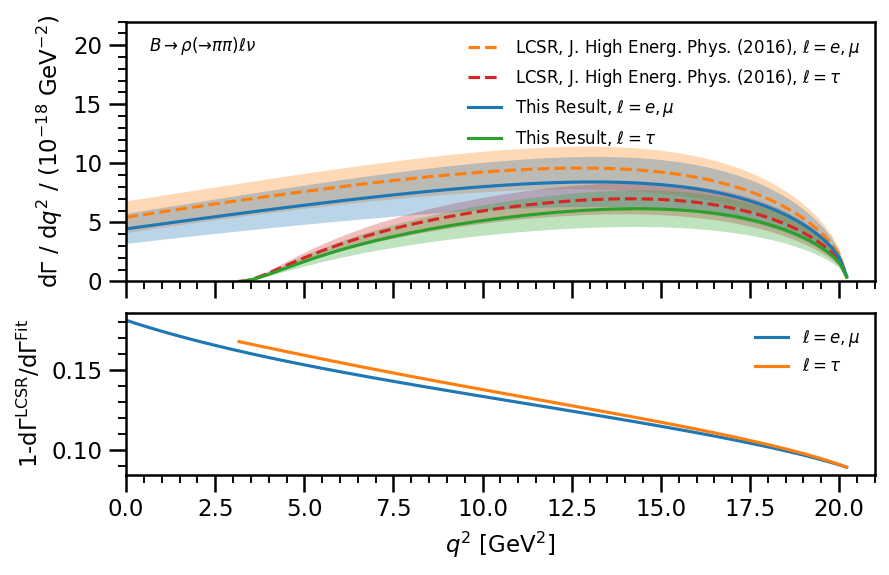

In [19]:
plotter_BToVLNuBCL_zma = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
plotter_BToVLNuBCL_tau = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=m_tau, V_ub=0)

q2_zma = np.linspace(plotter_BToVLNuBCL_zma.q2min+1e-2, plotter_BToVLNuBCL_zma.q2max-1e-2, num=100)
q2_tau = np.linspace(plotter_BToVLNuBCL_tau.q2min+1e-2, plotter_BToVLNuBCL_tau.q2max-1e-2, num=100)

fig, axs = plt.subplots(2, 1, figsize=(4*1.61, 4), dpi=150, sharex=True, gridspec_kw={"height_ratios": [1.61, 1], "hspace": 0.15,})
lw=1.5
markersize=5

ax = axs[0]

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL_zma.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL_zma.V_ub = uncertainties.ufloat(hflav_Vub, hflav_Vub_cov**0.5)
ax.plot(q2_zma, [uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) *1e18 for q2 in q2_zma], 
        color="tab:orange", ls='dashed',
        label=r"LCSR, J. High Energ. Phys. (2016), $\ell = e, \mu$")
ax.fill_between(q2_zma,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL_zma.dGamma_dq2(q2))) *1e18 for q2 in q2_zma],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL_zma.dGamma_dq2(q2))) *1e18 for q2 in q2_zma],
                facecolor="tab:orange", alpha=0.3)

plotter_BToVLNuBCL_tau.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL_tau.V_ub = uncertainties.ufloat(hflav_Vub, hflav_Vub_cov**0.5)
ax.plot(q2_tau, [uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) *1e18 for q2 in q2_tau], 
        color="tab:red", ls='dashed',
        label=r"LCSR, J. High Energ. Phys. (2016), $\ell = \tau$")
ax.fill_between(q2_tau,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL_tau.dGamma_dq2(q2))) *1e18 for q2 in q2_tau],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL_tau.dGamma_dq2(q2))) *1e18 for q2 in q2_tau],
                facecolor="tab:red", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL_zma.coefficients = uncertainties.correlated_values(fitted_coefficients, fitted_covariance)
plotter_BToVLNuBCL_zma.V_ub = uncertainties.ufloat(fitted_Vub, fitted_Vub_cov**0.5)
ax.plot(q2_zma, [uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) *1e18 for q2 in q2_zma], 
        color="tab:blue", ls='solid',
        label=r"This Result, $\ell = e, \mu$")
ax.fill_between(q2_zma,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL_zma.dGamma_dq2(q2))) *1e18 for q2 in q2_zma],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL_zma.dGamma_dq2(q2))) *1e18 for q2 in q2_zma],
                facecolor="tab:blue", alpha=0.3)

plotter_BToVLNuBCL_tau.coefficients = uncertainties.correlated_values(fitted_coefficients, fitted_covariance)
plotter_BToVLNuBCL_tau.V_ub = uncertainties.ufloat(fitted_Vub, fitted_Vub_cov**0.5)
ax.plot(q2_tau, [uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) *1e18 for q2 in q2_tau], 
        color="tab:green", ls='solid',
        label=r"This Result, $\ell = \tau$")
ax.fill_between(q2_tau,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL_tau.dGamma_dq2(q2))) *1e18 for q2 in q2_tau],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL_tau.dGamma_dq2(q2))) *1e18 for q2 in q2_tau],
                facecolor="tab:green", alpha=0.3)

ax.set_xlim(0, 21)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_ylabel(r'$\mathrm{d} \mathcal{\Gamma}$ / $\mathrm{d} q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)

ax = axs[1]

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL_zma.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL_zma.V_ub = uncertainties.ufloat(hflav_Vub, hflav_Vub_cov**0.5)
dgamma_zma_lcsr = np.array([uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) *1e18 for q2 in q2_zma])

plotter_BToVLNuBCL_tau.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL_tau.V_ub = uncertainties.ufloat(hflav_Vub, hflav_Vub_cov**0.5)
dgamma_tau_lcsr = np.array([uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) *1e18 for q2 in q2_tau])

# Plot Fit Result
plotter_BToVLNuBCL_zma.coefficients = uncertainties.correlated_values(fitted_coefficients, fitted_covariance)
plotter_BToVLNuBCL_zma.V_ub = uncertainties.ufloat(fitted_Vub, fitted_Vub_cov**0.5)
dgamma_zma_fit = np.array([uncertainties.nominal_value(plotter_BToVLNuBCL_zma.dGamma_dq2(q2)) *1e18 for q2 in q2_zma])

plotter_BToVLNuBCL_tau.coefficients = uncertainties.correlated_values(fitted_coefficients, fitted_covariance)
plotter_BToVLNuBCL_tau.V_ub = uncertainties.ufloat(fitted_Vub, fitted_Vub_cov**0.5)
dgamma_tau_fit = np.array([uncertainties.nominal_value(plotter_BToVLNuBCL_tau.dGamma_dq2(q2)) *1e18 for q2 in q2_tau])

plt.plot(q2_zma, 1-dgamma_zma_fit/dgamma_zma_lcsr, label=r"$\ell = e, \mu$")
plt.plot(q2_tau, 1-dgamma_tau_fit/dgamma_tau_lcsr, label=r"$\ell = \tau$")

ax.set_xlim(0, 21)
#ax.set_ylim(0.8, 0.95)

ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'1-$\mathrm{d}\Gamma^\mathrm{LCSR} / \mathrm{d}\Gamma^\mathrm{Fit}$')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)

plt.tight_layout()
plt.show()
plt.close()

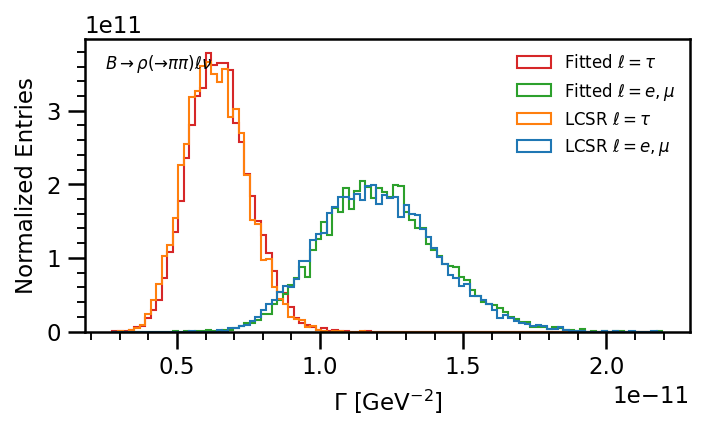

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.hist([integration_result_zma_lcsr, integration_result_tau_lcsr, integration_result_zma_fit, integration_result_tau_fit], 
        bins=100, histtype="step", density=True, label=[r"LCSR $\ell = e, \mu$", r"LCSR $\ell = \tau$", r"Fitted $\ell = e, \mu$", r"Fitted $\ell = \tau$"])

#ax.set_xlim(0, 24)
#ax.set_ylim(0, 22)

ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$\Gamma$ [GeV$^{-2}$]')
ax.set_ylabel(r'Normalized Entries')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

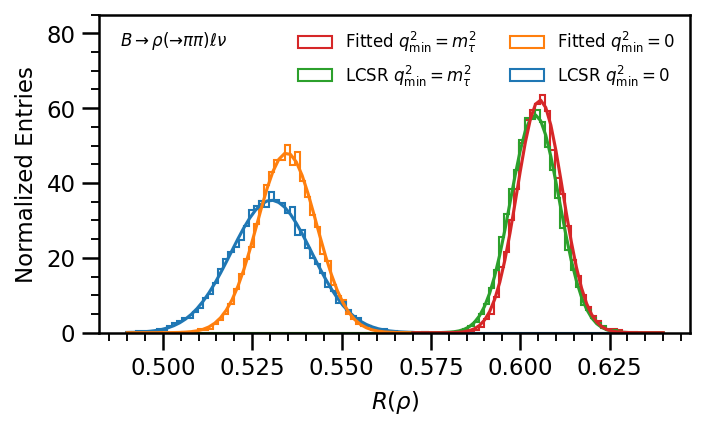

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.hist([r_lcsr, r_fit, r_lcsr_reduced, r_fit_reduced], 
        bins=100, histtype="step", density=True, 
        label=[r"LCSR $q^2_\mathrm{min}=0$", r"Fitted $q^2_\mathrm{min}=0$", r"LCSR $q^2_\mathrm{min}=m_\tau^2$", r"Fitted $q^2_\mathrm{min}=m_\tau^2$"])

ax.plot(
    np.linspace(0.49, 0.57),
    scipy.stats.norm(loc=r_lcsr.mean(), scale=r_lcsr.std()).pdf(np.linspace(0.49, 0.57)),
    color="tab:blue"
)

ax.plot(
    np.linspace(0.49, 0.57),
    scipy.stats.norm(loc=r_fit.mean(), scale=r_fit.std()).pdf(np.linspace(0.49, 0.57)),
    color="tab:orange"
)

ax.plot(
    np.linspace(0.57, 0.64),
    scipy.stats.norm(loc=r_lcsr_reduced.mean(), scale=r_lcsr_reduced.std()).pdf(np.linspace(0.57, 0.64)),
    color="tab:green"
)

ax.plot(
    np.linspace(0.57, 0.64),
    scipy.stats.norm(loc=r_fit_reduced.mean(), scale=r_fit_reduced.std()).pdf(np.linspace(0.57, 0.64)),
    color="tab:red"
)

#ax.set_xlim(0, 24)
ax.set_ylim(0, 85)

ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$R(\rho)$')
ax.set_ylabel(r'Normalized Entries')
ax.legend(loc=1, ncol=2, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

In [22]:
RV_lcsr = uncertainties.ufloat(r_lcsr.mean(), r_lcsr.std())
RV_fit = uncertainties.ufloat(r_fit.mean(), r_fit.std())
RV_lcsr_reduced = uncertainties.ufloat(r_lcsr_reduced.mean(), r_lcsr_reduced.std())
RV_fit_reduced = uncertainties.ufloat(r_fit_reduced.mean(), r_fit_reduced.std())

In [23]:
print("""
R\tR_LCSR\t\tR_Fit\t\tImprovement
R(V)\t{:.3f}\t{:.3f}\t{:.3f}
R(V)r\t{:.3f}\t{:.3f}\t{:.3f}
""".format(RV_lcsr, RV_fit, 1-RV_fit.std_dev/RV_lcsr.std_dev, 
           RV_lcsr_reduced, RV_fit_reduced, 1-RV_fit_reduced.std_dev/RV_lcsr_reduced.std_dev))


R	R_LCSR		R_Fit		Improvement
R(V)	0.530+/-0.011	0.535+/-0.008	0.263
R(V)r	0.604+/-0.007	0.605+/-0.006	0.064



## New Physics

In [24]:
def calculate_ratio(bcl_zma, bcl_tau, prandom, wcs=None):
    """..."""
    
    if wcs is None:
        wcs = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    q2_min = bcl_zma.q2min
    q2_max = bcl_zma.q2max
    m_tau2 = bcl_tau.q2min
    
    def mc_integration_wrapper(x, bcl, coefficients):
        """Minimalistic wrapper for use with `scipy.integrate.quad`."""
        bcl.coefficients = coefficients
        return bcl.dGamma_dq2_NP(x, wcs)
    
    zma = np.array([
        scipy.integrate.quad(lambda x: mc_integration_wrapper(x, bcl_zma, pran), q2_min, q2_max)[0] for pran in prandom
    ])
    
    zma_reduced = np.array([
        scipy.integrate.quad(lambda x: mc_integration_wrapper(x, bcl_zma, pran), m_tau2, q2_max)[0] for pran in prandom
    ])
    
    tau = np.array([
        scipy.integrate.quad(lambda x: mc_integration_wrapper(x, bcl_tau, pran), m_tau2, q2_max)[0] for pran in prandom
    ])
    
    return uncertainties.ufloat(np.mean(tau / zma), np.std(tau / zma)), uncertainties.ufloat(np.mean(tau / zma_reduced), np.std(tau / zma_reduced))

In [25]:
N_integrations = 100

In [26]:
prandom = scipy.stats.multivariate_normal.rvs(mean=fitted_coefficients, cov=fitted_covariance, size=N_integrations)

In [27]:
RV_SM = RV_fit
RV_SM_reduced = RV_fit_reduced

In [28]:
import copy
def modify_list(modify_item, value, list_in=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]):
    list_out = copy.copy(list_in)
    list_out[modify_item] = value
    return list_out

wcs_scan_range = np.linspace(-0.5, 0.5, num=20)

variations = {}
for wc_index in range(0, 11):
    variations[wc_index] = [modify_list(wc_index, wc_value) for wc_value in wcs_scan_range]

In [29]:
np_ratios = {}
for wc_index in range(0, 11):
    np_ratios[wc_index] = [calculate_ratio(bcl_integration, bcl_tau_integration, prandom, wc) for wc in variations[wc_index]]

In [30]:
def plot_band(ax, x, ratios, label, kind=0):
    ax.plot(wcs_scan_range, [r[kind].nominal_value for r in ratios], lw=1)
    ax.fill_between(wcs_scan_range, 
                    [r[kind].nominal_value - r[kind].std_dev for r in ratios],
                    [r[kind].nominal_value + r[kind].std_dev for r in ratios],
                    label=label, alpha=0.3, color=ax.lines[-1].get_color())
    ax.plot(wcs_scan_range, [r[kind].nominal_value - r[kind].std_dev for r in ratios], color=ax.lines[-1].get_color(), lw=0.3)
    ax.plot(wcs_scan_range, [r[kind].nominal_value + r[kind].std_dev for r in ratios], color=ax.lines[-1].get_color(), lw=0.3)

wc_labels = {
    1: r'$\chi_\mathrm{L}^\mathrm{S} \lambda_\mathrm{L}^\mathrm{S}$',
    2: r'$\chi_\mathrm{R}^\mathrm{S} \lambda_\mathrm{L}^\mathrm{S}$',
    3: r'$\chi_\mathrm{L}^\mathrm{V} \lambda_\mathrm{L}^\mathrm{V}$',
    4: r'$\chi_\mathrm{R}^\mathrm{V} \lambda_\mathrm{L}^\mathrm{V}$',
    5: r'$\chi_\mathrm{L}^\mathrm{T} \lambda_\mathrm{L}^\mathrm{T}$',
    6: r'$\chi_\mathrm{L}^\mathrm{S} \lambda_\mathrm{R}^\mathrm{S}$',
    7: r'$\chi_\mathrm{R}^\mathrm{S} \lambda_\mathrm{R}^\mathrm{S}$',
    8: r'$\chi_\mathrm{L}^\mathrm{V} \lambda_\mathrm{R}^\mathrm{V}$',
    9: r'$\chi_\mathrm{R}^\mathrm{V} \lambda_\mathrm{R}^\mathrm{V}$',
    10: r'$\chi_\mathrm{R}^\mathrm{T} \lambda_\mathrm{R}^\mathrm{T}$',
}

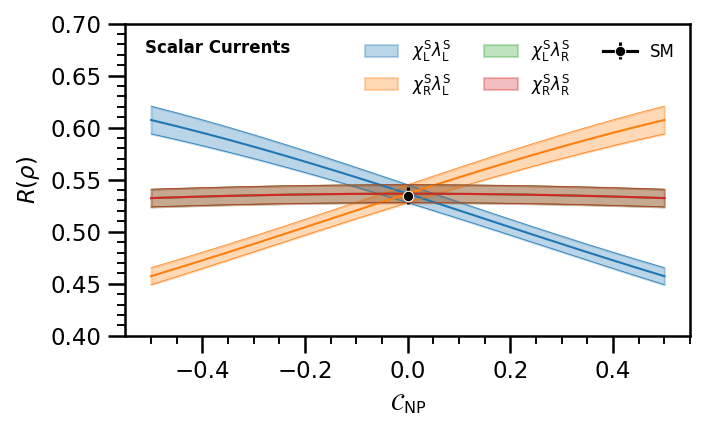

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

wcs_scan_range = np.linspace(-0.5, 0.5, num=20)

plot_band(ax, wcs_scan_range, np_ratios[1], wc_labels[1])
plot_band(ax, wcs_scan_range, np_ratios[2], wc_labels[2])
plot_band(ax, wcs_scan_range, np_ratios[6], wc_labels[6])
plot_band(ax, wcs_scan_range, np_ratios[7], wc_labels[7])

ax.errorbar(0, RV_SM.nominal_value, yerr=RV_SM.std_dev, label="SM", color="black", marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,)

ax.annotate(
    r'Scalar Currents', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 

ax.set_xlim(-0.55, 0.55)
ax.set_ylim(0.4, 0.7)

ax.set_xlabel(r'$\mathcal{C}_\mathrm{NP}$')
ax.set_ylabel(r'$R(\rho)$')
ax.legend(loc=1, ncol=3, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

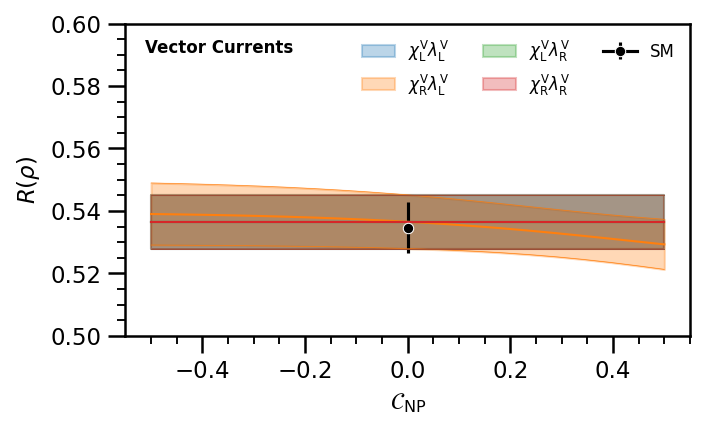

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

wcs_scan_range = np.linspace(-0.5, 0.5, num=20)

plot_band(ax, wcs_scan_range, np_ratios[3], wc_labels[3])
plot_band(ax, wcs_scan_range, np_ratios[4], wc_labels[4])
plot_band(ax, wcs_scan_range, np_ratios[8], wc_labels[8])
plot_band(ax, wcs_scan_range, np_ratios[9], wc_labels[9])

ax.errorbar(0, RV_SM.nominal_value, yerr=RV_SM.std_dev, label="SM", color="black", marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,)

ax.annotate(
    r'Vector Currents', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 

ax.set_xlim(-0.55, 0.55)
ax.set_ylim(0.5, 0.6)

ax.set_xlabel(r'$\mathcal{C}_\mathrm{NP}$')
ax.set_ylabel(r'$R(\rho)$')
ax.legend(loc=1, ncol=3, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

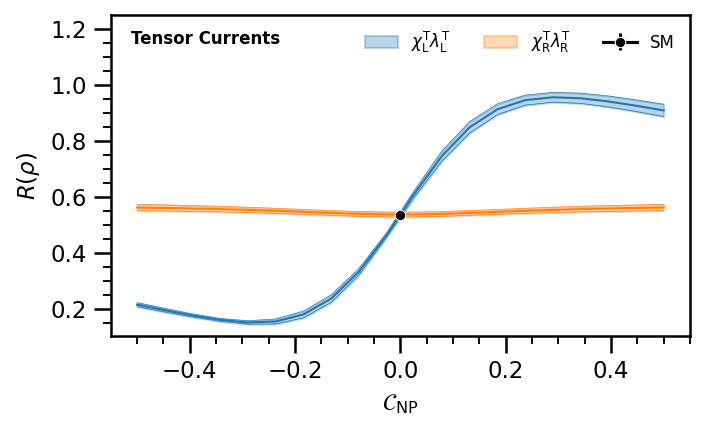

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

wcs_scan_range = np.linspace(-0.5, 0.5, num=20)

plot_band(ax, wcs_scan_range, np_ratios[5], wc_labels[5])
plot_band(ax, wcs_scan_range, np_ratios[10], wc_labels[10])

ax.errorbar(0, RV_SM.nominal_value, yerr=RV_SM.std_dev, label="SM", color="black", marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,)

ax.annotate(
    r'Tensor Currents', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlim(-0.55, 0.55)
ax.set_ylim(None, 1.25)

ax.set_xlabel(r'$\mathcal{C}_\mathrm{NP}$')
ax.set_ylabel(r'$R(\rho)$')
ax.legend(loc=1, ncol=3, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()